# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312,
 'dec_layers': 8}

In [11]:
base_path = Path('../../data/midi/v17/sf4/')
cache_name = 'tmp/hook_c'

## BERT Dataloading

In [12]:
ns_dl_tfms = [mask_tfm, next_sentence_tfm]
ns_config = config.copy()
ns_config['bs'] *= 2
ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                          y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

In [13]:
xb,yb = ns_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256]),
 torch.Size([32, 256])]

## S2S Dataloading

In [14]:
s2s_dl_tfms = [s2s_tfm]
s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                           preloader_cls=S2SPreloader, dl_tfms=s2s_dl_tfms, y_offset=1,
                           shuffle_dl=True, **config)


In [15]:
s2s_data.train_dl.dl.dataset.on_epoch_begin()
s2s_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = s2s_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256]),
 torch.Size([16, 256])]

### Load NextWord dataset (Language Model)

In [16]:

nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)
nw_data.vocab = vocab

## Datasets

In [17]:
dbs = [nw_data, s2s_data, ns_data]
cdb = CombinedData(dbs)

## Load

In [18]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [19]:
loss_func = BertLoss(loss_mult=(1,1,1,1))
learn = bert_model_learner(cdb, config.copy(), 
                           loss_func=loss_func)

In [20]:
learn.metrics = [mask_acc, nw_acc, s2s_acc, ns_acc]

In [21]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn))

In [22]:
learn = learn.to_fp16()

### Training

In [23]:
# learn.fit_one_cycle(12, 1e-4)

## Load existing

In [24]:
base_path/'models/unilm'
saved_models = get_files(base_path/'piano_duet/models/unilm', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/reencode_2_40ep.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hq/reencode_2_40ep_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/reencode_3_40ep_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/reencode_3_40ep.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/lq/reencode_2_24ep.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/lq/reencode_2_24ep_best.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/lq/reencode_1.pth'),
 PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/all/1_ep24_best.pth')]

In [25]:
load_path = saved_models[3]
state = torch.load(load_path, map_location='cpu')
get_model(learn.model).load_state_dict(state['model'], strict=False)
load_path

PosixPath('../../data/midi/v17/sf4/piano_duet/models/unilm/hook_c/reencode_3_40ep.pth')

## Predict Mask

In [273]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

title_filter = df['title'].str.contains('harry-potter')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results

,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
177691,verse,C,https://www.hooktheory.com/theorytab/view/jere...,midi_sources/hooktheory/pianoroll/j/jeremy-sou...,jeremy-soule,f11cfbd1d8123839ff933652b58727dd,sf4/piano_duet/hooktheory/pianoroll/j/jeremy-s...,0.0,harry-potter-and-the-chamber-of-secrets-menu-t...,Harry Potter and the Chamber of Secrets Menu T...,"intro,verse","Soundtrack,Video Game",NaN,hooktheory_c,1.0,6.0,128.0
177692,intro,C,https://www.hooktheory.com/theorytab/view/jere...,midi_sources/hooktheory/pianoroll/j/jeremy-sou...,jeremy-soule,00f3bb0862b42f9d225def0982c2d443,sf4/piano_duet/hooktheory/pianoroll/j/jeremy-s...,0.0,harry-potter-and-the-chamber-of-secrets-menu-t...,Harry Potter and the Chamber of Secrets Menu T...,"intro,verse","Soundtrack,Video Game",NaN,hooktheory_c,1.0,6.0,128.0
195467,intro,C,https://www.hooktheory.com/theorytab/view/alex...,midi_sources/hooktheory/pianoroll/a/alexandre-...,alexandre-desplat,090239d36242084eae48b63960bd36b9,sf4/piano_duet/hooktheory/pianoroll/a/alexandr...,0.0,statues---harry-potter-deathly-hallows-pt-2-ost,Statues - Harry Potter Deathly Hallows Pt 2 OST,intro,Soundtrack,NaN,hooktheory_c,1.0,4.0,64.0


In [276]:
idx = -1
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v17/sf4/piano_duet/hooktheory/pianoroll/a/alexandre-desplat/statues---harry-potter-deathly-hallows-pt-2-ost/intro_key_cmajor.npy'),
 PosixPath('../../data/midi/v17/midi_sources/hooktheory/pianoroll/a/alexandre-desplat/statues---harry-potter-deathly-hallows-pt-2-ost/intro_key_cmajor.mid'))

In [277]:
file2stream(orig).show('midi')

In [278]:
song_np = np.load(file)
xb = torch.tensor(to_single_stream(song_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

#### Regenerate durations

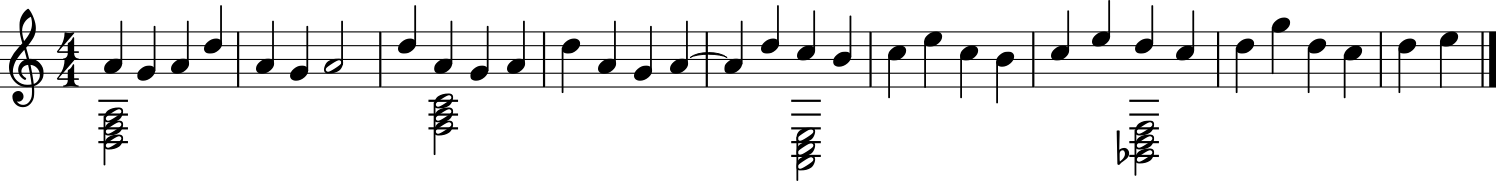

In [279]:
# duration mask
xb_dur = mask_input(xb, mask_range=vocab.dur_range)
pred = learn.predict_mask(xb_dur, temperatures=(0.8,0.8))
pred = to_double_stream(pred.cpu().numpy())

stream_dur = npenc2stream(pred)
stream_dur.show()

In [280]:
stream_dur.show('midi')

#### Regenerate Notes

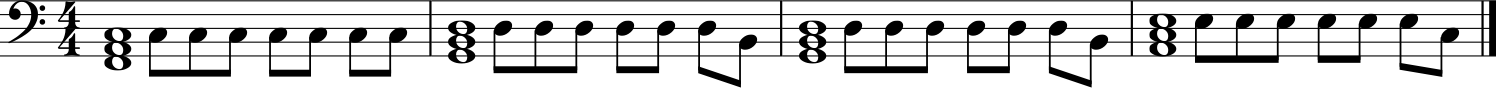

In [285]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
xb_note = mask_input(xb, mask_range=vocab.note_range)
pred_note = learn.predict_mask(xb_note, temperatures=(1.0, 1.0), top_p=0.5, top_k=24)
pred_note = to_double_stream(pred_note[:, 2:].cpu().numpy())

stream_note = npenc2stream(pred_note)
stream_note.show()

In [286]:
stream_note.show('midi')

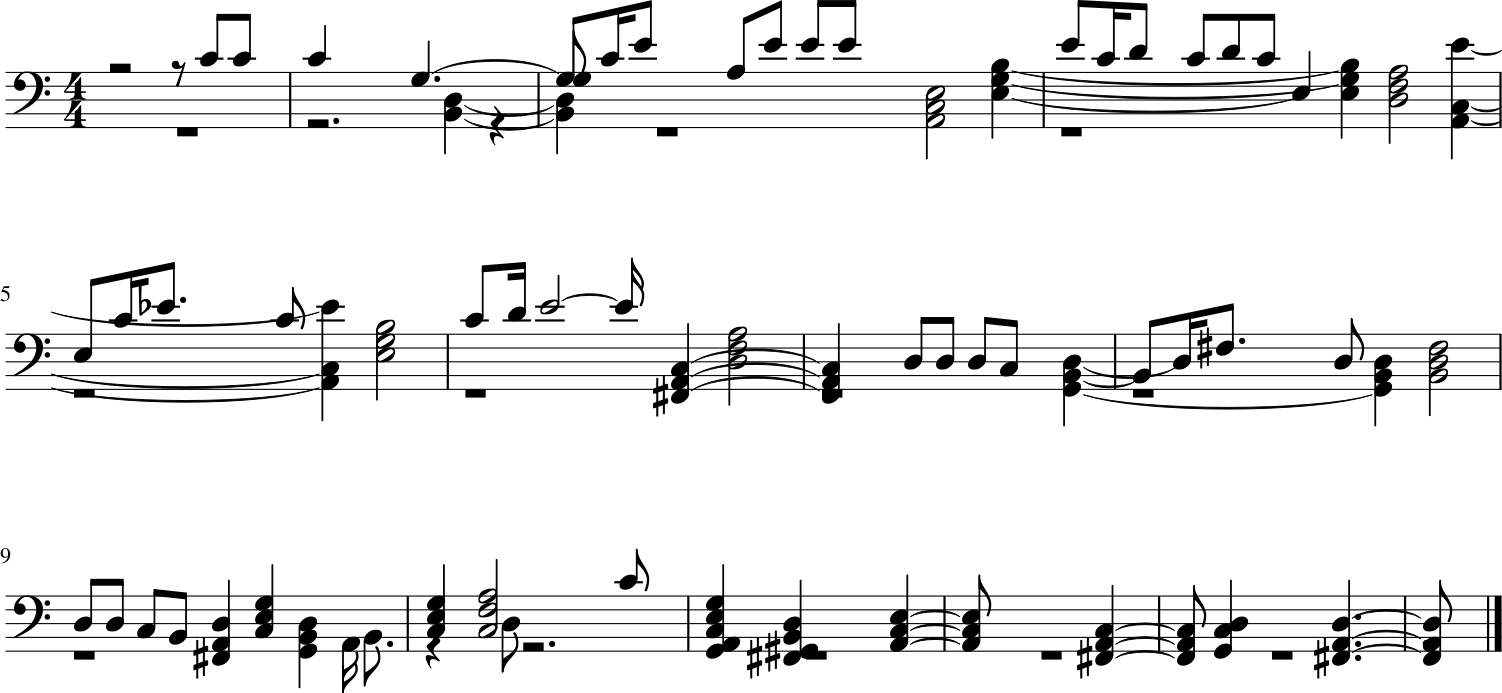

In [191]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
xb_note = mask_input(xb, mask_range=vocab.note_range)
pred_note = learn.predict_mask(xb_note)
pred_note = to_double_stream(pred_note.cpu().numpy())

stream_note = npenc2stream(pred_note)
stream_note.show()

In [ ]:
song_np = np.load(file)
xb = torch.tensor(to_single_stream(song_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [287]:
def mask_predict_from_midi(learn, midi=None,
                           temperatures=(1.0,1.0), top_k=20, top_p=0.8, 
                           predict_notes=True,
                           **kwargs):
    seed_np = midi2npenc(midi) # music21 can handle bytes directly
    xb = torch.tensor(to_single_stream(seed_np))[None]
    mask_range = vocab.note_range if predict_notes else vocab.dur_range
    xb = mask_input(xb, mask_range=vocab.note_range)
    if torch.cuda.is_available(): xb = xb.cuda()
    pred = learn.predict_mask(xb, temperatures=temperatures, top_k=top_k, top_p=top_p)
    pred = to_double_stream(pred)
    return pred

In [291]:
np.array([1,2]).copy()

array([1, 2])

In [293]:
out = mask_predict_from_midi(learn, orig)

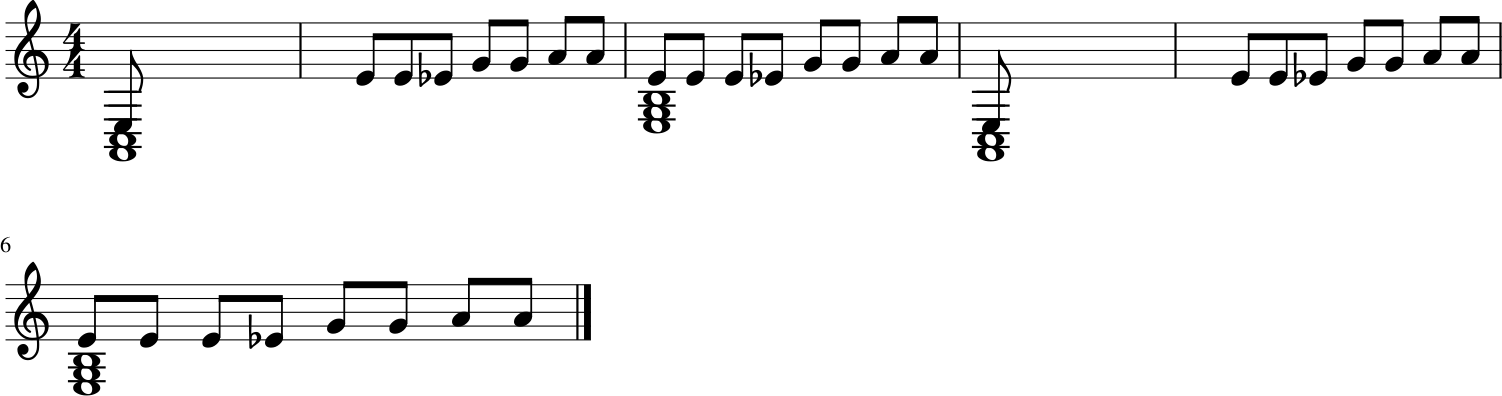

In [294]:
npenc2stream(out).show()

## Predict next word

In [146]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [147]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v17/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v17/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [148]:
seed_len = 60
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [149]:
out_s, seed_s = learn.predict_nw(xb, n_words=400)

Predicted BOS token. Returning prediction...


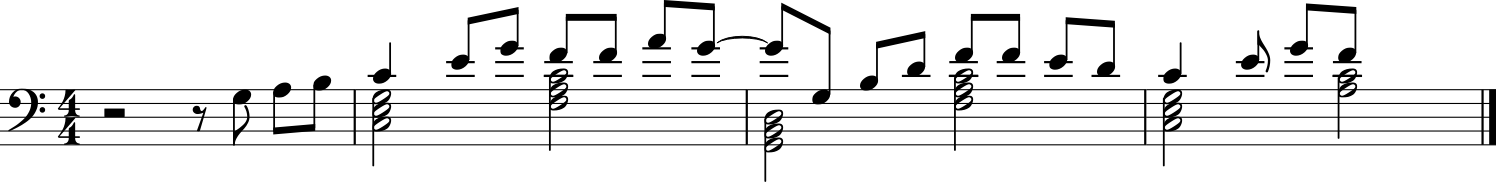

In [150]:
# Seed
npenc2stream(to_double_stream(seed_s)).show()

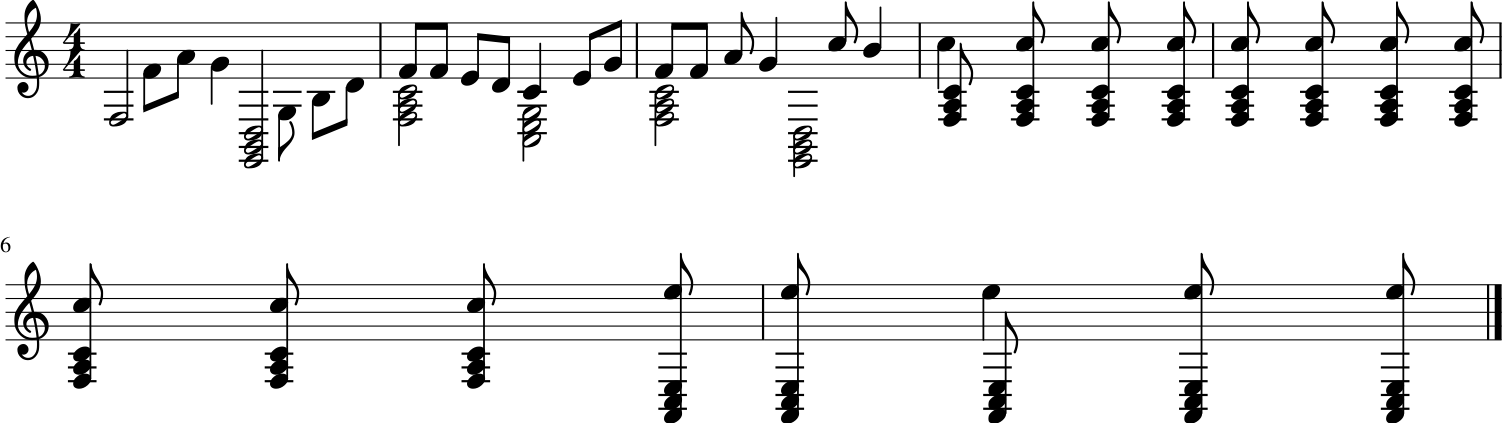

In [151]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [152]:
stream.show('midi')

In [ ]:
# full_stream = npenc2stream(to_double_stream(np.concatenate((seed_s, out_s))))
# full_stream.show()

## Predict Seq2Seq

In [171]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

title_filter = df['title'].str.contains('tong-hua')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

,ht_mode,title,genres,source,section,midi,artist,parts,ht_bpm,midi_title,ht_time_signature,ht_key,ht_offset,md5,song_url,numpy,mxl
178790,1.0,tong-hua,"Electronic,Pop",hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/g/guang-lian...,guang-liang,chorus,67.0,Tong Hua,4.0,C,0.0,2d80d686acf40368b07cf4a9099cb07e,https://www.hooktheory.com/theorytab/view/guan...,sf4/s2s_encode/hooktheory/pianoroll/g/guang-li...,NaN


In [172]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v17/sf4/s2s_encode/hooktheory/pianoroll/g/guang-liang/tong-hua/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v17/midi_sources/hooktheory/pianoroll/g/guang-liang/tong-hua/chorus_key_cmajor.mid'))

In [173]:
melody_np, chord_np = np.load(file, allow_pickle=True)

In [175]:
file2stream(orig).show('midi')

#### Predict melody (from chords)

In [176]:
m, c = s2s_file2parts(file, pred_melody=True)
xb = torch.tensor(c)[None].cuda()
yb = torch.tensor(m)[None].cuda()

In [180]:
# melody seed length
m_seed_len = 10
yb_out = learn.predict_s2s(xb, yb[:,:m_seed_len], n_words=250)

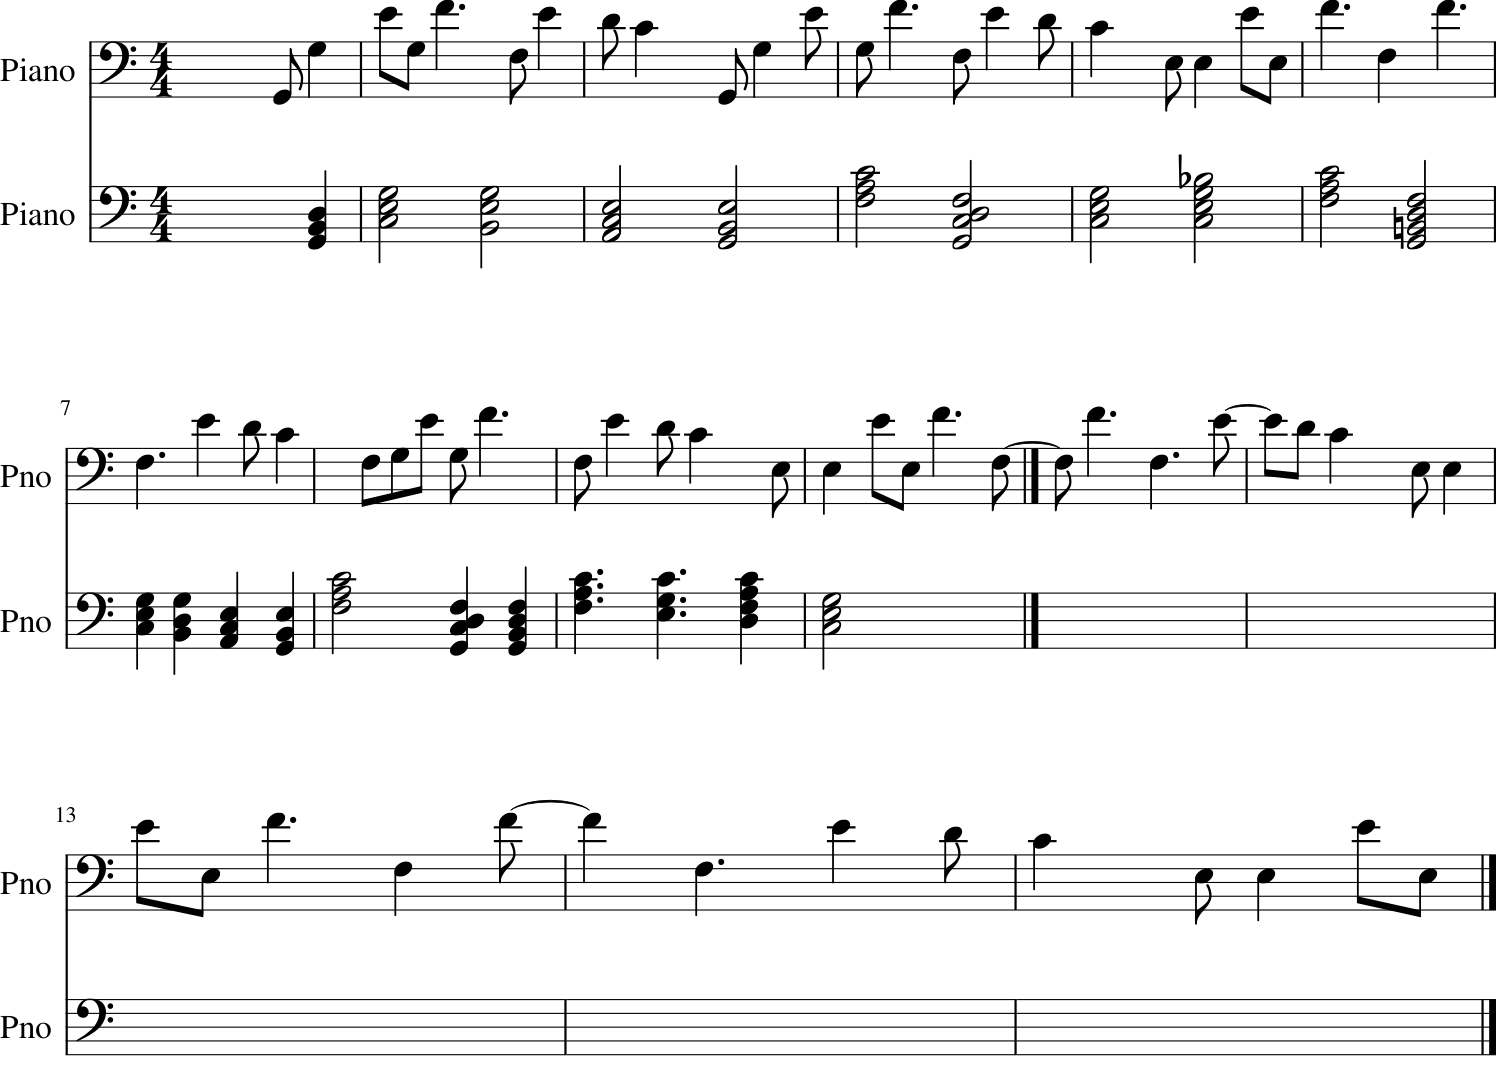

In [181]:
seed_npenc = to_double_stream(xb.cpu().numpy())
yb_npenc = to_double_stream(yb_out.cpu().numpy())
chordarr_comb = combined_npenc2chordarr(yb_npenc, seed_npenc)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [182]:
comb_stream.show('midi')

In [161]:
# out_stream = npenc2stream(yb_npenc)
# out_stream.show()
# out_stream.show('midi')

### Predict chords from melody - harmonization

In [162]:
m, c = s2s_file2parts(file, pred_melody=False)
xb = torch.tensor(m)[None].cuda()
yb = torch.tensor(c)[None].cuda()

In [163]:
# chord seed length
c_seed_len = 10
yb_out = learn.predict_s2s(xb, yb[:,:c_seed_len], n_words=250, temperatures=(0.7, 0.8), top_k=20)

Predicting BOS/EOS


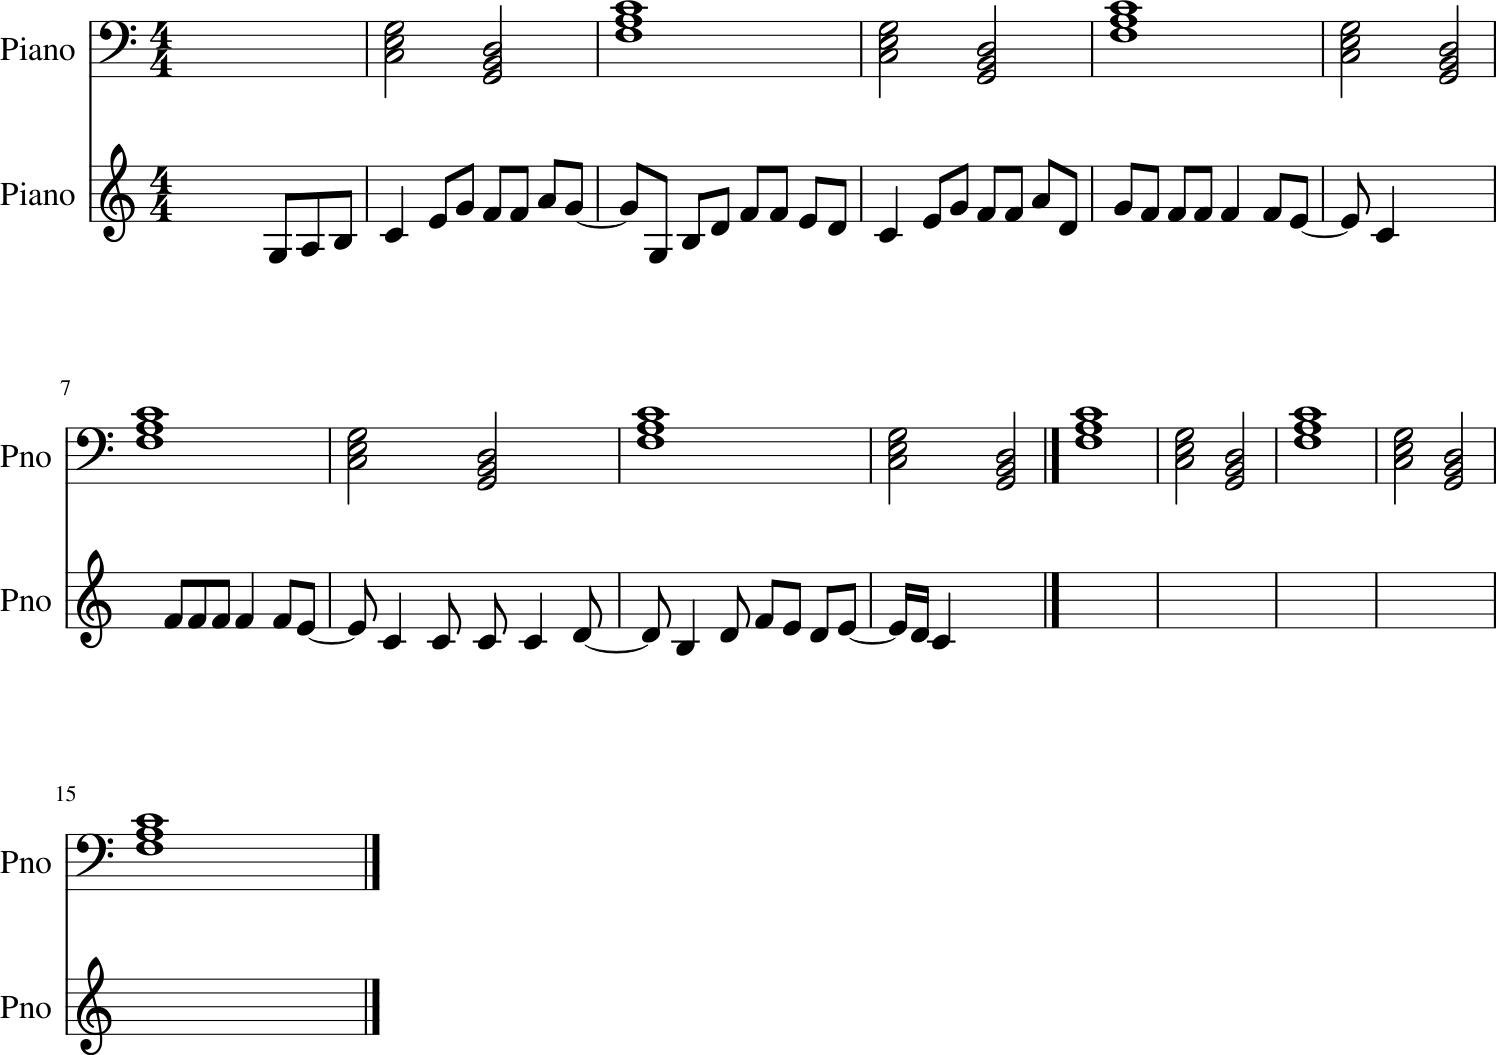

In [164]:
seed_npenc = to_double_stream(xb.cpu().numpy())
yb_npenc = to_double_stream(yb_out.cpu().numpy())
chordarr_comb = combined_npenc2chordarr(yb_npenc, seed_npenc)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [165]:
comb_stream.show('midi')